In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import absolute_import, print_function
import matplotlib.pyplot as plt
import pyopencl as cl
import numpy as np

## Inicializar contexto y cola de ejecución

In [3]:
ID_P = 0
ID_D = 2
platforms = cl.get_platforms()
devices = [platforms[ID_P].get_devices()[ID_D]]
context = cl.Context(devices=devices,properties=[(cl.context_properties.PLATFORM, platforms[ID_P])])
context.get_info(cl.context_info.DEVICES)
queue = cl.CommandQueue(context, properties=cl.command_queue_properties.OUT_OF_ORDER_EXEC_MODE_ENABLE)
queue.get_info(cl.command_queue_info.CONTEXT)

<pyopencl.Context at 0x5640cbb3f8e0 on <pyopencl.Device 'GeForce RTX 2080' on 'NVIDIA CUDA' at 0x5640cc7576c0>>

## Código fuente y compilación del programa


In [14]:
kernel='''
__kernel void copy_channel(__global float *img_input, __global float *img_output, uint c){
    
    uint y = get_global_id(0);
    uint x = get_global_id(1);
    
    uint h = get_global_size(0);
    uint w = get_global_size(1);
    uint offset = (y*w)+x;
  
    
    img_output[offset] = img_input[(h*w*c)+offset];
    
}
'''

prg = cl.Program(context, kernel)
exe = prg.build(options=[])

## Cargar imagen de prueba

float32


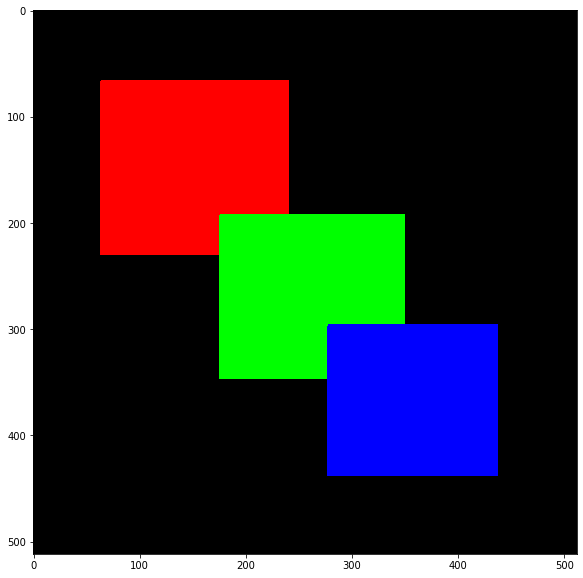

(4, 512, 512) (512, 512)


In [16]:
host_color = plt.imread("colors.png")
print(host_color.dtype)
plt.figure(figsize=(10,10))
plt.imshow(host_color,'gray')
plt.show()

host_color = np.transpose(host_color, [2, 0, 1]).copy()
host_gray = np.zeros(host_color.shape[1:],dtype=host_color.dtype)

print(host_color.shape, host_gray.shape)

## Inicialización de memoria y copia al dispositivo

In [17]:
device_color = cl.Buffer(context, cl.mem_flags.READ_WRITE, size=host_color.nbytes)
device_gray = cl.Buffer(context, cl.mem_flags.READ_WRITE, size=host_gray.nbytes)
cl.enqueue_copy(queue, device_color, host_color, is_blocking=False, wait_for=None)

## Ejecución del kernel

0.0 1.0


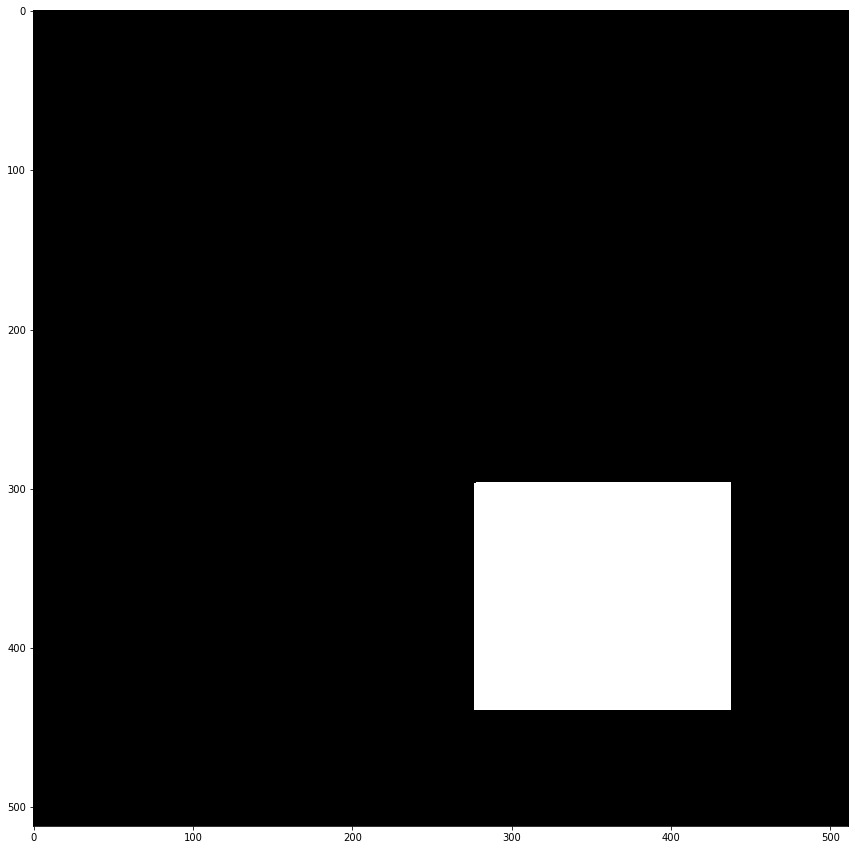

In [24]:
channel=2
exe.copy_channel(queue, (512,512), None, device_color, device_gray, np.uint32(channel))
cl.enqueue_copy(queue, host_gray, device_gray, is_blocking=True, wait_for=None)
print(host_gray.min(), host_gray.max())

plt.figure(figsize=(15,15))
plt.imshow(host_gray,'gray')
plt.show()